# Optimizers

In [1]:
import pathlib
import numpy as np
from qu3st.nts_solver import NTSSolver
from qu3st.optimizers.classical.cplex.objective_function import get_weights

root_path = pathlib.Path()

In [2]:
def print_summary(result):
    print(f'CANDIDATE SOLUTION:')
    print(f"Settled transactions:\n"
          f"{result.transactions}")
    print(f"Collateral Usage:\n"
          f"{result.collateral}")
    print(f"Cash balance indicators:\n"
          f"{result.cb_indicators}")
    print(f"CMB-security-position links indicators:\n"
          f"{result.spl_indicators}")
    print(f"Payoff: {result.evaluation}")
    print(f"Time elapsed: {result.runtime} sec.")
    print()


def check_validity(solution, model, instance):
    # retrieve solution values
    transactions = solution.transactions
    collateral = solution.collateral
    cb_indicators = solution.cb_indicators
    spl_indicators = solution.spl_indicators

    # generate new cplex solution according to the retrieved values
    possible_mp_solution = model.new_solution()
    indicators = np.concatenate((transactions, spl_indicators, cb_indicators))

    for i, v in enumerate(model.iter_binary_vars()):
        possible_mp_solution.add_var_value(v, indicators[i])
        # print(f"{v}: {indicators[i]}", end=" ")

    for i, v in enumerate(model.iter_integer_vars()):
        possible_mp_solution.add_var_value(v, collateral[i])
        # print(f"{v}: {collateral[i]}", end=" ")

    # print validity-check summary
    print()
    print("Unsatisfied constraints:")
    print(possible_mp_solution.find_unsatisfied_constraints(model))
    print("Is it a valid solution?")
    print(possible_mp_solution.is_valid_solution())
    print("Cplex payoff:")
    weights = get_weights(instance, lam=0.5)
    print(np.sum(weights * solution.transactions))

In [3]:
# load an instance (base data root: modules/ntsp/data):
# f = "2024-05-05_15-26-01/5_0_TFT.json"
f = "data/gs_5.json"

## Classical

### CPLEX

In [4]:
# initialize cplex configuration
config = {
    "ntsp": {
        "res_path": str(root_path / "temp"),
        "sanitize": True
    },
    "solver": {
        "lam": 0.5,
        "opt_mode": "CPLEX",
        "opt_options": {
            "verbose": True,
            "collateral": True
        },
    }
}

# initialize solver and compute solution
x = NTSSolver(mode="json", optimizer="classical", **config["ntsp"])
cplex_solution = x.optimize(data=f, **config["solver"])

# optimization summary
print_summary(cplex_solution)
print(
    f"Solution Status: {cplex_solution.custom_params['details'].status.upper()}"
    f" - Relative Gap:"
    f" {cplex_solution.custom_params['details'].mip_relative_gap}")

# initialize ground-truth and auto-check cplex solution
cplex_model = cplex_solution.model.model
instance = cplex_solution.model.instance
check_validity(solution=cplex_solution, model=cplex_model, instance=instance)

Results and logs for this run will be stored in:
	temp\classical_2025-06-22_11-45-53

-- cannot find parameters matching version: 22.1.2.0, using: 22.1.1.0
CANDIDATE SOLUTION:
Settled transactions:
[0 1 1 1 1]
Collateral Usage:
[]
Cash balance indicators:
[0 0 0 0 0]
CMB-security-position links indicators:
[]
Payoff: 2.0326510892392888e-08
Time elapsed: 0.0 sec.

Solution Status: INTEGER OPTIMAL SOLUTION - Relative Gap: 0.0

Unsatisfied constraints:
[]
Is it a valid solution?
True
Cplex payoff:
2.0326510892392888e-08


## Quantum

### QTSA

Results and logs for this run will be stored in:
	temp\quantum_2025-06-22_10-21-40



d:\Projects_D\Security Transaction Settlement\Qu3ST\venv\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:243: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


AttributeError: 'PrimitiveJob' object has no attribute 'tags'

<Figure size 640x480 with 0 Axes>

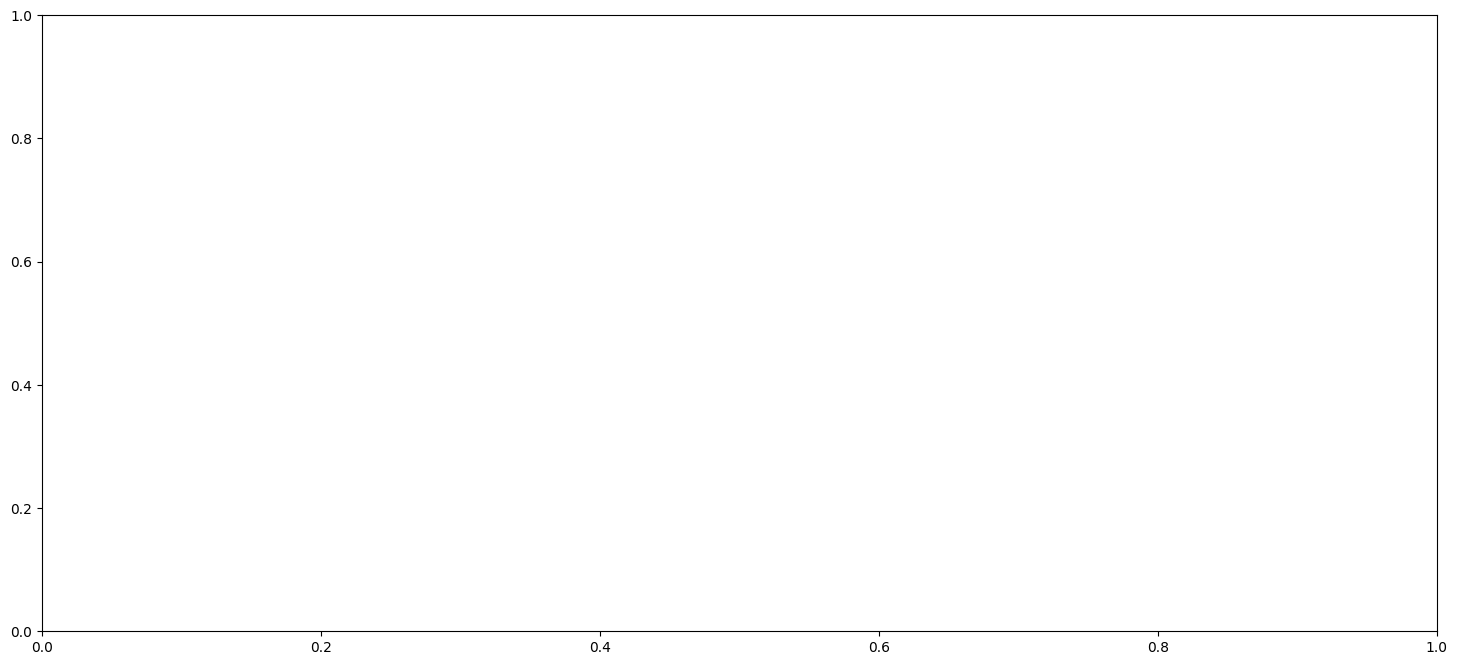

In [5]:
# initialize qtsa configuration
opt_config = {
    "ntsp": {
        "res_path": str(root_path / "temp"),
        "sanitize": False,
        "reload": True,
        "mode": "json"
    },
    "solver": {
        "opt_mode": "MBD",
        "opt_options": {
            "ansatz": "hardware_efficient",
            "ansatz_options": {
                "rep": 2
            },
            "backend": "fake",
            "backend_options": {
                "name": "fake_melbourne"
            },
            "primitive": "sampler",
            "primitive_options": {
                "mitigation_options": {
                    # "calibration_lifetime": 3600 * 3,
                    "dd": {"sequence_type": "XpXm"},
                    "rem": {
                        "hammer": {
                            "mit_sample_mode": "zero",
                            "iterative": True,
                            "iter_weights": False,
                            "max_hd": None
                        }
                    }
                }
            },
            "shots": 100,
            "verbose": True,
            "gamma": 1,
            "minimizer": "BAYESIAN",
            "minimizer_options": {
                "maxiter": 25,
                "sd": 0.2,
                "reload": True,
                "log_file": "./tmp.log",
            },
            "of_options": {
                "lam": 0.5,
                "gamma": 1,  # 10 ** -15,
                "activation_function": "relogist",
            }
        }
    }
}

try:
    # compute solution and print summary
    x = NTSSolver(optimizer="quantum", **opt_config["ntsp"])
    mbd_result = x.optimize(data=f, **opt_config["solver"])
    print_summary(mbd_result)
    check_validity(solution=mbd_result, model=cplex_model, instance=instance)
except MemoryError:
    print("NTS problem instance is too large.")
